## PyTorch Computer Vision

In [1]:
import torch 
import torch.nn as nn
import torchvision
from  torchvision import datasets
from torchvision import models
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

print(torch.__version__)
print(torchvision.__version__)

c:\Users\dagam\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.2.0+cu121
0.17.0+cu121


## Import Fashion MNIST

In [2]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

print(len(train_data), len(test_data))

class_names = train_data.classes # no indexes just names dict
class_to_idx = train_data.class_to_idx # names with indexes dict
print(class_to_idx)

image, label = train_data[0]
print(image.shape, label, train_data.targets) # one color label

60000 10000
{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}
torch.Size([1, 28, 28]) 9 tensor([9, 0, 0,  ..., 3, 0, 5])


## Visualize Data

Image shape : torch.Size([1, 28, 28])


(-0.5, 27.5, 27.5, -0.5)

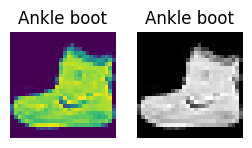

In [3]:
image, label = train_data[0]
print(f"Image shape : {image.shape}")
#plt.imshow(image) # error cause color channel first
fig = plt.figure(figsize=(3, 6))
fig.add_subplot(1, 2, 1)
plt.imshow(image.squeeze())
plt.title(class_names[label])
plt.axis(False)
fig.add_subplot(1, 2, 2)
plt.imshow(image.squeeze(), cmap = 'gray')
plt.title(class_names[label])
plt.axis(False)

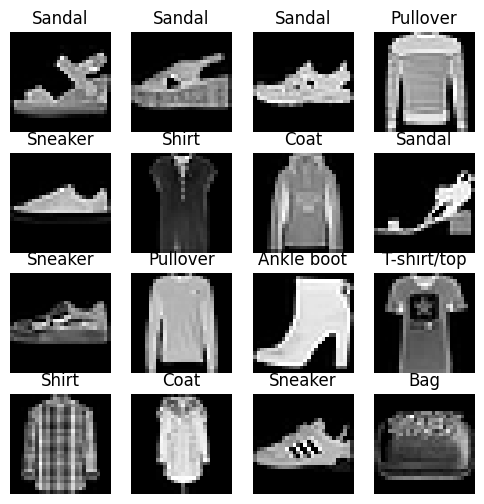

In [4]:
# more images
# torch.manual_seed(42)
fig = plt.figure(figsize=(6,6))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    rand_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[rand_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(class_names[label])
    plt.axis(False)

## Prepare DataLoader
(Converts dataset into python iterable) + (Batches/mini-Batches)
* Batches(usually 32) = more commputationally efficient(not all hardware can store all in mem in one go) + Gives NN more chances to update its gradients per epoch

In [5]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [6]:
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset = train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True) # Good cause dataset can have similar images nearby
test_dataloader = DataLoader(dataset = test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False) # For eval its good to not shuffle

In [7]:
print(f"DataLoader: {train_dataloader, test_dataloader}")
print(f"Number of Batches of Train DataLoader: {len(train_dataloader)} batches of {train_dataloader.batch_size}")
print(f"Number of Batches of Test DataLoader : {len(test_dataloader)} batches of {test_dataloader.batch_size}") # gets rounded up if not divisible

DataLoader: (<torch.utils.data.dataloader.DataLoader object at 0x0000026F7E70D210>, <torch.utils.data.dataloader.DataLoader object at 0x0000026F0049FED0>)
Number of Batches of Train DataLoader: 1875 batches of 32
Number of Batches of Test DataLoader : 313 batches of 32


In [8]:
train_features_batch , train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape # color channels first, varies prob to prob

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 7, label size: torch.Size([])


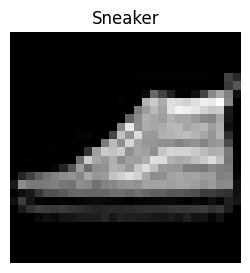

In [9]:
# Show a sample from batch
torch.manual_seed(42)
rand_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[rand_idx], train_labels_batch[rand_idx]
plt.figure(figsize=(3,3))
plt.imshow(img.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

## Creating Baseline Model
Start simple and add complexity where necessary

In [10]:
flatten_model = nn.Flatten()

x = train_features_batch[0]
print(x.shape)
out = flatten_model(x)
print(out.shape)

torch.Size([1, 28, 28])
torch.Size([1, 784])


In [11]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hidden_units: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    def forward(self, x):
        return self.layer_stack(x)

In [12]:
torch.manual_seed(42)
model_0 = FashionMNISTModelV0(input_shape=784, hidden_units=10, output_shape=len(class_names)).to('cpu')

dummy_X = torch.rand([1,1,28,28])
model_0(dummy_X)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr = 0.01)

### Own helper function script

In [13]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("Already Exists, Skipping download")
else:
    print("Downloading Helper Functions script")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import accuracy_fn

Already Exists, Skipping download


### Time experiments
for performance(loss and acc) and speed(latency)

In [14]:
from timeit import default_timer as timer
def print_train_time(start:float, end:float, device:torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [15]:
start_time = timer()
# Some code
end_time = timer()
print_train_time(start=start_time, end=end_time, device='cpu')

Train time on cpu: 0.000 seconds


2.4300000177390757e-05

## Train Loop on batches of data

In [16]:
# import tqdm for progress bar
from tqdm.auto import tqdm
torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch} \n----")
    #Training
    train_loss = 0 # for per batch
    #Loop through training batches
    for batch, (X,y) in enumerate(train_dataloader):
        model_0.train()
        y_pred = model_0(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulate every batch and then div by num of batches for avg
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() # does once per batch not per epoch in batches

        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")

    train_loss /= len(train_dataloader) # avg out across

    test_loss, test_acc = 0 , 0

    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader: # no need to keep track of batches
            test_pred = model_0(X_test)
            test_loss += loss_fn(test_pred, y_test) # accumulate
            test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1)) # convert raw outputs(logits) into labels (skipping softmax)

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(f"\nTrain Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Test acc: {test_acc:.4f}") 

train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(train_time_start_on_cpu, train_time_end_on_cpu, str(next(model_0.parameters()).device))  

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 
----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 33%|███▎      | 1/3 [00:07<00:15,  7.59s/it]


Train Loss: 0.5645 | Test Loss: 0.5088 | Test acc: 82.2384
Epoch: 1 
----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 67%|██████▋   | 2/3 [00:15<00:07,  7.51s/it]


Train Loss: 0.5013 | Test Loss: 0.4899 | Test acc: 83.0471
Epoch: 2 
----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


100%|██████████| 3/3 [00:22<00:00,  7.33s/it]


Train Loss: 0.4809 | Test Loss: 0.5726 | Test acc: 80.4712
Train time on cpu: 22.008 seconds


## Make predictions and get results
make a function to track models

In [17]:
torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available else 'cpu'

def eval_model(model:torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, accuracy_fn, device=device):
    """
    Returns a dictionary containing the results of model predicting on data_loader
    """

    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1)) # convert raw outputs(logits) into labels (skipping softmax)
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name" : model.__class__.__name__, # only works for model created in class
            "model_loss" : loss.item(), # converts to single value
            "model_acc" : acc}


model_0_results = eval_model(model=model_0, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device='cpu')
model_0_results

100%|██████████| 313/313 [00:00<00:00, 428.30it/s]


{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.5725626945495605,
 'model_acc': 80.47124600638978}

In [18]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape:int, output_shape:int, hidden_units:int) -> None:
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )

    def forward(self, x):
        return self.layer_stack(x)

torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784, output_shape=len(class_names), hidden_units=10).to(device)
# next(model_1.parameters()).device

from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

# functionizing Loops
def train_step(model:torch.nn.Module, data_loader:torch.utils.data.DataLoader, loss_fn:torch.nn.Module, optimizer: torch.optim.Optimizer, accuracy_fn, device:torch.device = device):
    """
    Performs a testing loop step on model going over dataloader
    """

    train_loss, train_acc = 0, 0
    model.train()
    for batch, (X,y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train Loss: {train_loss:.5f} | Train Acc: {train_acc:.2f}%")

def test_step(model:torch.nn.Module, data_loader:torch.utils.data.DataLoader, loss_fn:torch.nn.Module, accuracy_fn, device:torch.device = device):
    """
    Performs a testing loop step on model going over dataloader
    """
    test_loss , test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader: # no need to keep track of batches
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y) # accumulate
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1)) # convert raw outputs(logits) into labels (skipping softmax)

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(f"Test Loss: {test_loss:.4f} | Test acc: {test_acc:.2f}%") 

from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch}\n-----")
    train_step(model = model_1,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    test_step(model = model_1,
               data_loader=test_dataloader,
               loss_fn=loss_fn,
               accuracy_fn=accuracy_fn,
               device=device)
    
train_time_end_on_gpu = timer()

total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu, end=train_time_end_on_gpu, device=device)

model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=device)
model_1_results

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0
-----
Train Loss: 1.42962 | Train Acc: 53.82%


 33%|███▎      | 1/3 [00:08<00:16,  8.34s/it]

Test Loss: 1.1259 | Test acc: 61.12%
Epoch 1
-----
Train Loss: 1.03311 | Train Acc: 64.74%


 67%|██████▋   | 2/3 [00:18<00:09,  9.66s/it]

Test Loss: 0.9983 | Test acc: 64.83%
Epoch 2
-----
Train Loss: 0.96039 | Train Acc: 66.03%


100%|██████████| 3/3 [00:29<00:00,  9.90s/it]


Test Loss: 0.9609 | Test acc: 65.46%
Train time on cuda: 29.716 seconds


100%|██████████| 313/313 [00:01<00:00, 232.44it/s]


{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.9608814120292664,
 'model_acc': 65.45527156549521}

## Model 2 Building a CNN

In [19]:
class FashionMNISTModelV2(nn.Module): # Replicate TinyVGG
    def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),# hyperparams
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape) # Trick to calc this (0)
        )
    
    def forward(self, x):
        x = self.conv_block_1(x)
        # print(x.shape) to resolve flatten size mismatch and 7*7 issues
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        return x
    
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1, hidden_units=10, output_shape=len(class_names)).to(device)

## Working of Conv and maxpool

In [20]:
rand_image_tensor = torch.randn(size=(1,28,28))
rand_image_tensor.shape

torch.Size([1, 28, 28])

In [21]:
model_2(rand_image_tensor.unsqueeze(0).to(device))

tensor([[ 0.0366, -0.0940,  0.0686, -0.0485,  0.0068,  0.0290,  0.0132,  0.0084,
         -0.0030, -0.0185]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [22]:
torch.manual_seed(42)
images = torch.randn(size = (32,3,64,64))
test_image = images[0]

print(images.shape, test_image.shape)

torch.Size([32, 3, 64, 64]) torch.Size([3, 64, 64])


In [23]:
test_image.unsqueeze(0).shape

torch.Size([1, 3, 64, 64])

In [24]:
conv_layer = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=1)
max_pool_layer = nn.MaxPool2d(kernel_size=2)
conv_output = conv_layer(test_image.unsqueeze(0))
max_output = max_pool_layer(conv_output)
print(conv_output.shape, max_output.shape)


torch.Size([1, 10, 64, 64]) torch.Size([1, 10, 32, 32])


In [25]:
torch.manual_seed(42)
random_tesnor = torch.randn(size=(1,1,2,2))
max_pool_layer = nn.MaxPool2d(kernel_size=2)
max_output = max_pool_layer(random_tesnor)
print(random_tesnor.shape, max_output.shape)
print(random_tesnor, '\n' ,max_output)

torch.Size([1, 1, 2, 2]) torch.Size([1, 1, 1, 1])
tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]]) 
 tensor([[[[0.3367]]]])


## Training CNN

In [26]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as Timer
train_time_start_model_2 = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    train_step(model=model_2,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    test_step(model=model_2,
               data_loader=test_dataloader,
               loss_fn=loss_fn,
               accuracy_fn=accuracy_fn,
               device=device)

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start= train_time_start_model_2, end=train_time_end_model_2, device=device)

model_2_results = eval_model(model=model_2,
                            data_loader=test_dataloader,
                            loss_fn=loss_fn,
                            accuracy_fn=accuracy_fn,
                            device=device)

model_2_results

  0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.60847 | Train Acc: 78.10%


 33%|███▎      | 1/3 [00:10<00:20, 10.03s/it]

Test Loss: 0.3963 | Test acc: 86.06%
Train Loss: 0.36432 | Train Acc: 86.80%


 67%|██████▋   | 2/3 [00:19<00:09,  9.80s/it]

Test Loss: 0.3584 | Test acc: 86.97%
Train Loss: 0.32632 | Train Acc: 88.12%


100%|██████████| 3/3 [00:29<00:00,  9.76s/it]


Test Loss: 0.3235 | Test acc: 88.36%
Train time on cuda: 29.278 seconds


100%|██████████| 313/313 [00:00<00:00, 332.04it/s]


{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.32346266508102417,
 'model_acc': 88.35862619808307}

            model_name  model_loss  model_acc  training_time
0  FashionMNISTModelV0    0.572563  80.471246      22.008404
1  FashionMNISTModelV1    0.960881  65.455272      29.716122
2  FashionMNISTModelV2    0.323463  88.358626      29.277698


Text(0, 0.5, 'model')

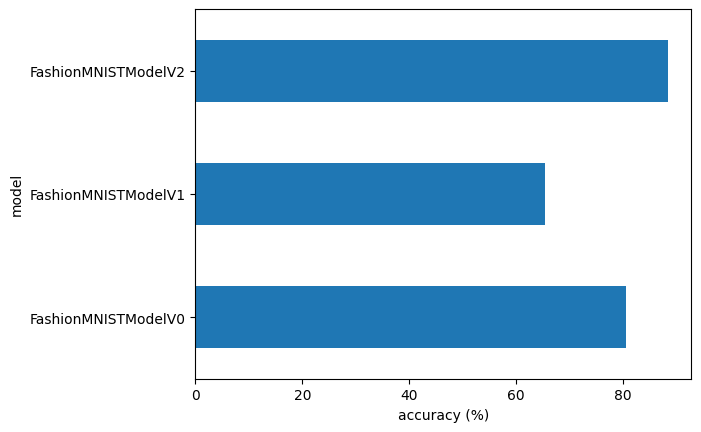

In [27]:
import pandas as pd

compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results["training_time"] = [total_train_time_model_0, total_train_time_model_1, total_train_time_model_2]
print(compare_results)
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model")

## Getting predictions

torch.Size([1, 28, 28]) 9


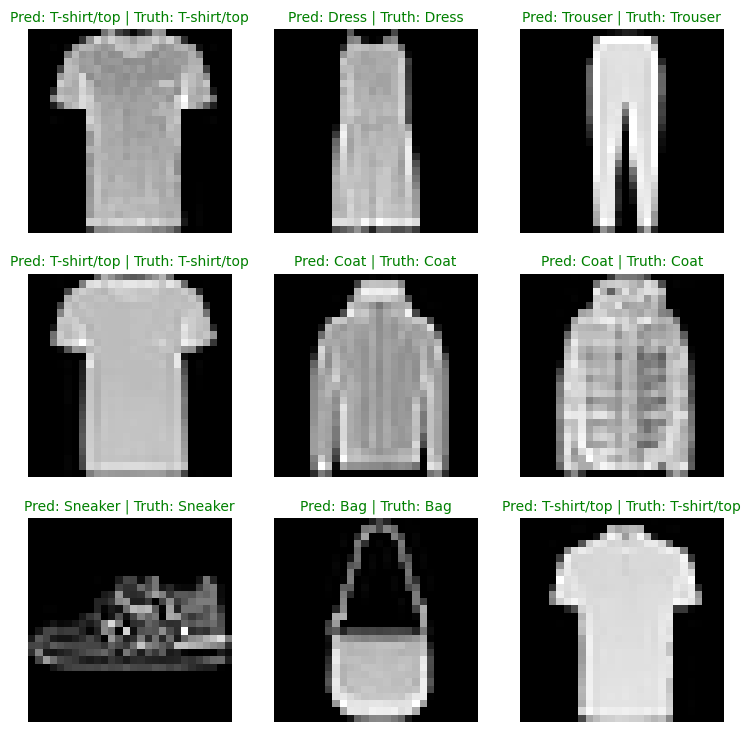

In [28]:
def make_predictions(model:torch.nn.Module,
                     data:list,
                     device:torch.device = device):
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            pred_logits = model(sample) # logits cause last layer linear
            pred_prob = torch.softmax(pred_logits.squeeze(), dim=0)# logit to pred prob
            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)

img, label = test_data[0][:10]
print(img.shape, label)

import random
# random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k = 9):
    test_samples.append(sample)
    test_labels.append(label)

# plt.imshow(test_samples[0].squeeze(), cmap='gray')
# plt.title(test_labels[0])

pred_prob = make_predictions(model_2, test_samples)
pred_classes = pred_prob.argmax(dim=1)
# print(pred_prob[:2], pred_classes, test_labels)

plt.figure(figsize=(9,9))
nrows = 3
ncols = 3
for i, sample in  enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(sample.squeeze(), cmap='gray')
    pred_label = class_names[pred_classes[i]]
    truth_label = class_names[test_labels[i]]
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c='g')
    else:
        plt.title(title_text, fontsize=10, c='r')
    plt.axis(False)

## Evaluating Model (Confusion Matrix)

In [29]:
from tqdm.auto import tqdm

y_preds = []
model_2.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions..."):
        X, y = X.to(device), y.to(device)
        y_logit = model_2(X)
        y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
        y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:10], len(y_pred_tensor)

Making predictions...: 100%|██████████| 313/313 [00:01<00:00, 225.87it/s]


(tensor([9, 2, 1, 1, 6, 4, 4, 6, 5, 7]), 10000)

In [30]:
try:
    import torchmetrics, mlxtend
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend version should be 0.19.0 or higher"
    print(mlxtend.__version__)
except:
    !pip install -q torchmetrics -U mlxtend
    import torchmetrics, mlxtend
    # print(mlxtend.__version__)

0.23.1


In [31]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds= y_pred_tensor, target=test_data.targets)
confmat_tensor


tensor([[650,   5,  46,  59,   9,   1, 220,   0,  10,   0],
        [  8, 824,   4, 121,  35,   0,   5,   0,   3,   0],
        [ 10,   2, 806,  11, 116,   0,  49,   0,   6,   0],
        [ 31,   9,  26, 840,  44,   0,  40,   0,   8,   2],
        [  3,   4, 124,  42, 728,   0,  90,   0,   9,   0],
        [  5,   1,   3,   8,   0, 836,   6,  62,  55,  24],
        [ 79,   5, 127,  53,  98,   0, 625,   0,  13,   0],
        [  1,   0,   0,   0,   0,  23,   0, 929,   7,  40],
        [  9,   2,  21,   8,   9,   7,  19,   6, 917,   2],
        [  0,   0,   0,   0,   0,  21,   3,  93,   4, 879]])

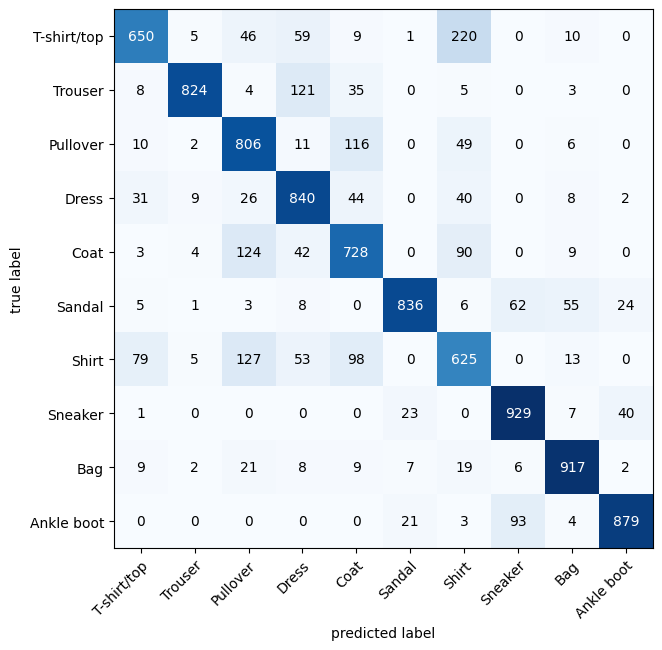

In [32]:
fig, axis = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(), class_names=class_names, figsize=(10,7))

## Save and Load best performing model

In [33]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "3_Computer Vision model.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

print(f"Saving Model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), f=MODEL_SAVE_PATH)

torch.manual_seed(42)
loaded_model_2 = FashionMNISTModelV2(input_shape=1, hidden_units=10, output_shape=len(class_names))
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model_2.to(device)

Saving Model to: models\3_Computer Vision model.pth


FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [34]:
#Eval loaded model to check if same results as saved
torch.manual_seed(42)
loaded_model_2_results = eval_model(model=loaded_model_2,data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn)
print(torch.isclose(torch.tensor(model_2_results["model_loss"]), torch.tensor(loaded_model_2_results["model_loss"]), atol=1e-02))
loaded_model_2_results, model_2_results

100%|██████████| 313/313 [00:01<00:00, 227.14it/s]

tensor(True)


({'model_name': 'FashionMNISTModelV2',
  'model_loss': 0.32346266508102417,
  'model_acc': 88.35862619808307},
 {'model_name': 'FashionMNISTModelV2',
  'model_loss': 0.32346266508102417,
  'model_acc': 88.35862619808307})